# Stereo Rectification

Rectify a pair of stereo images (e.g.: http://www.diegm.uniud.it/fusiello/papers/mva99.pdf)

*You need to run the last block first to execute the code*

calculate yaw=0.0
calculate yaw=0.39269908169872414
calculate yaw=0.7853981633974483
calculate yaw=1.1780972450961724
calculate yaw=1.5707963267948966
calculate yaw=1.9634954084936207
calculate yaw=2.356194490192345
calculate yaw=2.748893571891069
calculate yaw=3.141592653589793
calculate yaw=3.5342917352885173
calculate yaw=3.9269908169872414
calculate yaw=4.319689898685965
calculate yaw=4.71238898038469
calculate yaw=5.105088062083414
calculate yaw=5.497787143782138
calculate yaw=5.890486225480862


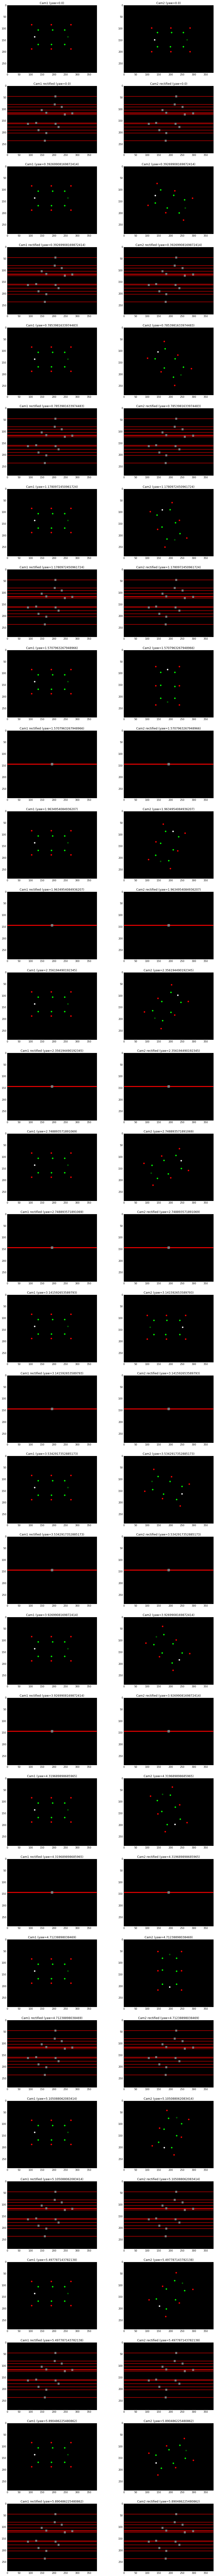

In [4]:
def rectify(Cam1, Cam2):
    """
    'A compact algorithm for rectification of stereo pairs'
    by [Andrea Fusiello, Emanuele Trucco, Alessandro Verri]
    
    return:
        P_n1: np.array, 3x4 - projection matrix for first img
        P_n2: np.array, 3x4 - projection matrix for second img
    
    """
    
    P_o1 = pinhole_projection(
        Cam1['pos'].squeeze(), Cam1['R'], Cam1['K'])
    P_o2 = pinhole_projection(
        Cam2['pos'].squeeze(), Cam2['R'], Cam2['K'])
    
    A1,R1,t1 = art(P_o1)
    A2,R2,t2 = art(P_o2)
    
    
    Q_o1 = P_o1[0:3,0:3]
    q_o1 = P_o1[0:3:,3:4]
    Q_o2 = P_o2[0:3,0:3]
    q_o2 = P_o2[0:3:,3:4]
    
    c1 = - np.linalg.inv(Q_o1) @ q_o1
    c2 = - np.linalg.inv(Q_o2) @ q_o2
    
    # new x-axis (direction of baseline)
    v1 = c1 - c2
    
    # new y-axis (orthogonal to new x and old z)
    v1_ = [float(v1[0]), float(v1[1]), float(v1[2])]
    z_ = [float(R1[:3,2:3][0]), 
          float(R1[:3,2:3][1]), 
          float(R1[:3,2:3][2])]
    v2 = np.cross(z_, v1_)
    
    v2_ = [float(v2[0]), float(v2[1]), float(v2[2])]
    
    v2 = np.expand_dims(v2, axis=1)
    
    # new z-axis
    v3 = np.cross(v1_, v2_)
    v3 = np.expand_dims(v3, axis=1)
    
    e1 = v1.T / np.linalg.norm(v1)
    e2 = v2.T / np.linalg.norm(v2)
    e3 = v3.T / np.linalg.norm(v3)
        
    R = np.array([
            e1, e2, e3
        ])
    
    R = np.squeeze(R)
    
    # new intrinsic params
    A = (A1 + A2) / 2
    
    # new projection matrix
    P_n1 = np.zeros_like(P_o1)
    P_n1[0:3,0:3] = R
    P_n1[0:3,3:4] = -R @ c1
    P_n1 = A @ P_n1
    
    P_n2 = np.zeros_like(P_o2)
    P_n2[0:3,0:3] = R
    P_n2[0:3,3:4] = -R @ c2
    P_n2 = A @ P_n2
    
    Q_n1 = P_n1[0:3,0:3]
    Q_n2 = P_n2[0:3,0:3]
    
    # rectifying image transformation
    T1 = Q_n1 @ np.linalg.inv(Q_o1)
    T2 = Q_n2 @ np.linalg.inv(Q_o2)
    
    return P_n1, P_n2

def art(P):
    """
    Decompose projection matrix into intrinsic and
    extrinsic parameters
    
    Parameters:
        P: np.array, 3x4 - projection matrix
    
    return:
        A: np.array, 3x3 - intrinsic camera parameters
        R: np.array, 3x3 - camera rotation matrix
        t: np.array, 3x1 - translate camera coord space
                        into world coord space origin
    """
    Q = np.linalg.inv(P[0:3,0:3])
    U,B = np.linalg.qr(Q)
    R = np.linalg.inv(U)
    
    t = B @ P[0:3,3]
    A = np.linalg.inv(B)
    A = A / A[2,2]
    return A,R,t

def paper_algorithm(Cam1, Cam2, points3d, img1, img2):
    """
    A compact algorithm for rectification of stereo pairs
    """

    P1, P2 = rectify(Cam1, Cam2)

    I1 = np.zeros((H, W, 3), "int8")
    I2 = np.zeros((H, W, 3), "int8")
    draw_rectified_epi_lines(I1, I2, P1, points3d)

    I1 = draw_image(
        points3d, P1, W, H, I=I1, wert=63,
        pixel_size=85, pos=Cam1['pos'],
        callback_behindcam=lambda x: print('behind.. ' + str(x)))

    I2 = draw_image(
        points3d, P2, W, H, I=I2, wert=63,
        pixel_size=85, pos=Cam2['pos'])
    
    return I1, I2

plot_rectification(paper_algorithm)

### OpenCV implementation

below the OpenCV rectification is used

calculate yaw=0.0
calculate yaw=0.39269908169872414
calculate yaw=0.7853981633974483
calculate yaw=1.1780972450961724
calculate yaw=1.5707963267948966
calculate yaw=1.9634954084936207
calculate yaw=2.356194490192345
calculate yaw=2.748893571891069
calculate yaw=3.141592653589793
calculate yaw=3.5342917352885173
calculate yaw=3.9269908169872414
calculate yaw=4.319689898685965
calculate yaw=4.71238898038469
calculate yaw=5.105088062083414
calculate yaw=5.497787143782138
calculate yaw=5.890486225480862


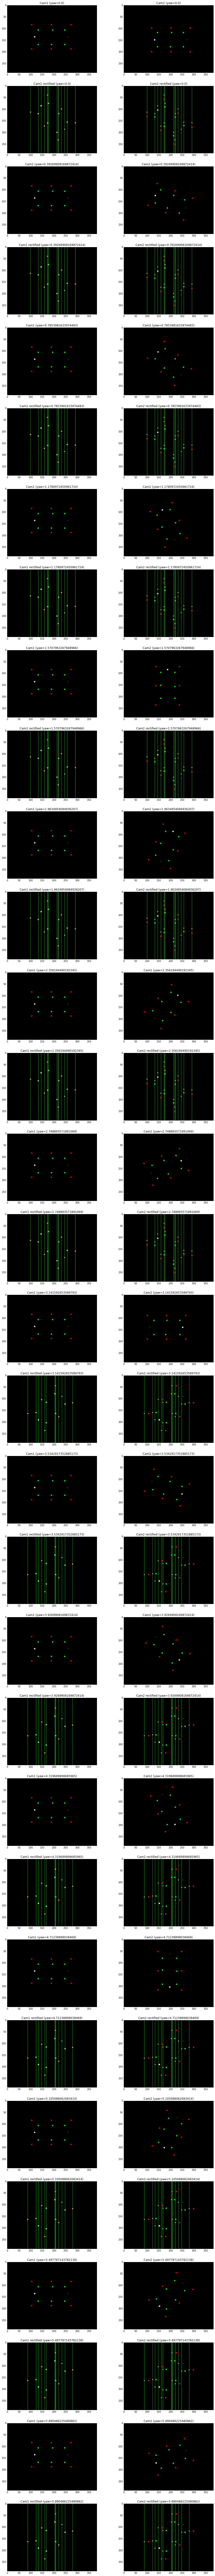

In [129]:
def opencv_algorithm(Cam1, Cam2, points3d, img1, img2):
    """
    OpenCV implementation for rectification
    """

    I1 = np.zeros((H, W, 3), "int8")
    I2 = np.zeros((H, W, 3), "int8")
    
    T1 = get_tvec(Cam1)
    T2 = get_tvec(Cam2)
    
    A1 = Cam1['K']
    A2 = Cam2['K']
    Size = (W,H)
    
    R1 = Cam1['R']
    R2 = Cam2['R']
    
    points2d_1 = project_3d_to_2d(Cam1, points3d)
    points2d_2 = project_3d_to_2d(Cam2, points3d)
    
    #rig_onto_img(img1, points2d_1)
    #rig_onto_img(img2, points2d_2)
    
    flags = cv2.CALIB_FIX_INTRINSIC
    
    retval, A1, dist1, A2, dist2, R, T, E, F = \
        cv2.stereoCalibrate(
            np.array([points3d], 'float32'), 
            np.array([points2d_1], 'float32'),
            np.array([points2d_2], 'float32'),
            A1, 0,
            A2, 0,
            Size,
            flags=flags
        )
    
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        A1, dist1, A2, dist2, Size, R, T)
    
    map1, map2 = cv2.initUndistortRectifyMap(
        A1, dist1, R1, P1, Size, cv2.CV_32FC1)
    
    I1 = cv2.remap(img1, map1, map2, cv2.INTER_AREA)
    
    
    map1, map2 = cv2.initUndistortRectifyMap(
        A2, dist1, R2, P2, Size, cv2.CV_32FC1)
    
    I2 = cv2.remap(img2, map1, map2, cv2.INTER_AREA)
    
    
    I1, I2 = lines(I1, I2)
    
    #cv2.rectangle(I2, \
    #    (roi2[0], roi2[1]),\
    #    (roi2[0]+roi2[2], roi2[1]+roi2[3]),\
    #    (255,0,0),
    #    thickness=10)
    
    
    
    return I1, I2

plot_rectification(opencv_algorithm, small=False)

---

## Paint functions

In [125]:
W = 2560
H = 1920
W = int(W * 1.5)
H = int(H * 1.5)

# =================================
# Functions
# =================================

def lines(img1, img2, count_points=14):
    
    A = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    A = (A > 0) * 100
    A = cv2.blur(A, (50, 50))
    
    W = img1.shape[1]
    H = img1.shape[0]
    
    for i in range(count_points):
        _, _, _, maxLoc = cv2.minMaxLoc(A)
        cv2.circle(A, maxLoc, 100, (0,0,0), -1)
        
        y_pos = maxLoc[1] + 20
        x_pos = maxLoc[0]
        cv2.circle(img1, maxLoc, 20, (255, 255, 255), -1)
        cv2.circle(img2, maxLoc, 20, (255, 255, 255), -1)
        
        #cv2.line(img1, (0, y_pos), (W, y_pos), (255,0,0), thickness=10)
        #cv2.line(img2, (0, y_pos), (W, y_pos), (255,0,0), thickness=10)
        
        cv2.line(img1, (x_pos, 0), (x_pos, H), (0,250,0), thickness=7)
        cv2.line(img2, (x_pos, 0), (x_pos, H), (0,250,0), thickness=7)
        
    
    return img1, img2
    

def plot_rectification(rectify, small=False):
    
    assert(callable(rectify))
    
    # ============================
    # Data
    # ============================

    calib_A = np.array([20.0, 90.0, 50.0])  # Light-Green
    calib_B = np.array([130.0, 90.0, 50.0])  # White

    calib_C = np.array([  # Red
        (10.0, 90.0, 10.0),
        (75.0, 90.0, 10.0),
        (140.0, 90.0, 10.0),
        (140.0, 90.0, 90.0),
        (75.0, 90.0, 90.0),
        (10.0, 90.0, 90.0)
    ])

    calib_D = np.array([  # Green
        (20.0, 16.0, 20.0),
        (75.0, 16.0, 20.0),
        (130.0, 16.0, 20.0),
        (130.0, 16.0, 80.0),
        (70.0, 16.0, 80.0),
        (20.0, 16.0, 80.0)
    ])

    points3d = [calib_A, calib_B]
    points3d.extend(calib_C)
    points3d.extend(calib_D)
    
    # ==========================
    # Run it
    # ==========================

    Yaws = [
        math.pi/8 * 0,
        math.pi/8 * 1,
        math.pi/8 * 2,
        math.pi/8 * 3,
        math.pi/8 * 4,
        math.pi/8 * 5,
        math.pi/8 * 6,
        math.pi/8 * 7,
        math.pi/8 * 8,
        math.pi/8 * 9,
        math.pi/8 * 10,
        math.pi/8 * 11,
        math.pi/8 * 12,
        math.pi/8 * 13,
        math.pi/8 * 14,
        math.pi/8 * 15
    ]
    if small:
        Yaws = [
            math.pi/8 * 0,
            math.pi/8 * 1,
            math.pi/8 * 2
        ]

    fig = plt.figure(figsize=(16, 2 * 6 * (len(Yaws))))

    for i, yaw in enumerate(Yaws):
        print("calculate yaw=" + str(yaw))
        ax = fig.add_subplot(2*len(Yaws), 2, i * 4 + 1)
        ay = fig.add_subplot(2*len(Yaws), 2, i * 4 + 2)
        bx = fig.add_subplot(2*len(Yaws), 2, i * 4 + 3)
        by = fig.add_subplot(2*len(Yaws), 2, i * 4 + 4)
        
        run(ax,ay,bx,by,yaw, rectify, points3d)


def run(ax, ay, bx, by, yaw, rectify, points3d):
    assert(callable(rectify))
    Cam1 = {
        'pos': np.array(
            [72.5, 381.4, 43.3]),
        'K': np.array([
            [-3765.698429142333, 0.0000000000002, W/2],\
            [0, -3765.6984291423264, H/2],\
            [0, 0, 1]]).astype('float'),
        'R': rotate_apa(roll=math.pi/2 * 3 + 0.001,pitch=0,yaw=0.0001)
    }

    Cam2 = {
        'pos': np.array(
            [82.5, 381.4, 53.3]),
        'K': np.array([
            [-3680, 0.000000000006, W/2],\
            [0, -3680, H/2],\
            [0, 0, 1]]).astype('float'),
        'R': rotate_apa(roll=math.pi/2 * 3 + 0.001,pitch=0,yaw=yaw + 0.0001)
    }
    
    # ====================================
    # "A compact algorithm for rectification of stereo pairs"
    # ====================================

    img1, img2 = img(Cam1, points3d), img(Cam2, points3d)
    
    I1, I2 = rectify(Cam1, Cam2, points3d, img1, img2)
    
    # ====================================
    # plot
    # ====================================
    
    
    # make this less memory expensive..
    factor = 10
    img1 = scipy.misc.imresize(img1, (int(H/factor), int(W/factor)))
    img2 = scipy.misc.imresize(img2, (int(H/factor), int(W/factor)))
    I1 = scipy.misc.imresize(I1, (int(H/factor), int(W/factor)))
    I2 = scipy.misc.imresize(I2, (int(H/factor), int(W/factor)))
    
    ax.set_title("Cam1 (yaw=" + str(yaw) + ")")
    ax.imshow(img1)
    ay.set_title("Cam2 (yaw=" + str(yaw) + ")")
    ay.imshow(img2)
    
    bx.set_title("Cam1 rectified (yaw=" + str(yaw) + ")")
    bx.imshow(I1)
    by.set_title("Cam2 rectified (yaw=" + str(yaw) + ")")
    by.imshow(I2)


---

## Helper functions

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import scipy.misc

def img(Cam, points3d):
    """
    Creates the 'photo' taken from a camera
    """
    points2d = project_3d_to_2d(Cam, points3d)

    I = np.zeros((H,W,3), "uint8")

    for i, p in enumerate(points2d):
        color = (0, 50, 0)
        if i == 1:
            color = (255, 255, 255)
        elif i > 1 and i < 8:
            color = (255, 0, 0)
        elif i >= 8:
            color = (0, 255, 0)

        center = (int(p[0]), int(p[1]))
        cv2.circle(I, center, 30, color, -1)

    return I

def rig_onto_img(img, points2d):
    for i, p in enumerate(points2d):
        color = (0, 50, 0)
        if i == 1:
            color = (255, 255, 255)
        elif i > 1 and i < 8:
            color = (255, 0, 0)
        elif i >= 8:
            color = (0, 255, 0)

        center = (int(p[0]), int(p[1]))
        cv2.circle(img, center, 50, color, 12)
    return img

def get_tvec(Cam):
    R = Cam['R']
    pos = Cam['pos']
    return np.expand_dims(
        np.linalg.inv(-np.transpose(R)) @ pos,
        axis=1
    ).astype('float64')
    

def project_3d_to_2d(Cam, points3d):
    """
    This is a 'dummy' function to create the image for
    the rectification/stereo-calibration.
    """
    R = Cam['R']
    pos = Cam['pos']
    K = Cam['K'].astype('float32')

    # pos to tvec
    tvec = np.expand_dims(
        np.linalg.inv(-np.transpose(R)) @ pos,
        axis=1
    ).astype('float64')

    # rot to rvec
    rvec = cv2.Rodrigues(R)[0].astype('float64')

    points2d, _ = cv2.projectPoints(
        np.array(points3d), rvec, tvec, K, 0)
    return np.ndarray.squeeze(points2d).astype('float32')

def draw_rectified_epi_lines(I1, I2, Pn1, points3d, debug=False):
    for (u,v) in get_2d_points(points3d, Pn1):
        cv2.line(I1, (0,v), (9999,v), (255,0,0), thickness=15)
        cv2.line(I2, (0,v), (9999,v), (255,0,0), thickness=15)
        if debug:
            print("point at " + str((u,v)))

def rotate_apa(roll=0, pitch=0, yaw=0):
    """
    Creates a 3d rotation matrix with the
    given rotations around the respective
    axis. The order in which the rotations
    are applied is:
        
        ROLL -> PITCH -> YAW
        (Aircraft principle axes)
    
    Parameters:
        roll: {float} [0, 2*math.pi]
        pitch: {float} [0, 2*math.pi]
        yaw: {float} [0, 2*math.pi]
        
    return:
        np.array([]), 3x3, float
    """
    Rx = np.array([[1, 0, 0],
                  [0, math.cos(roll), -math.sin(roll)],
                  [0, math.sin(roll), math.cos(roll)]])
    Ry = np.array([[math.cos(pitch), 0, math.sin(pitch)],
                   [0, 1, 0],
                  [-math.sin(pitch), 0, math.cos(pitch)]]) 
    Rz = np.array([[math.cos(yaw), -math.sin(yaw), 0],
                   [math.sin(yaw), math.cos(yaw), 0],
                   [0,0,1]])
    return Rz @ Ry @ Rx

def pinhole_projection(cam_pos, R, K):
    """
    Create a 4x3 projection matrix for a pinhole
    camera
    
    Parameters:
        cam_pos: {np.array} 3,1 camera position in world coords
        R: {np.array} 3,3 orthonormal rotation matrix
        K: {np.array} 3,3 intrinsic camera matrix
        
    return:
        4x3 projection matrix
    """
    C = np.array(cam_pos)
    assert(R.shape == (3,3))
    assert(C.shape == (3,))
    assert(K.shape == (3,3))
    assert(np.isclose(1, np.linalg.norm(R[:,0])))
    assert(np.isclose(1, np.linalg.norm(R[:,1])))
    assert(np.isclose(1, np.linalg.norm(R[:,2])))
    
    # == create extrinsic camera matrix
    T = -R @ C
    T = np.expand_dims(T, axis=1)
    E = np.zeros((3,4))
    E[0:,0:3] = R
    E[0:,3:] = T
    
    P = K @ E
    return P

def draw_image(
    points3d, P, w, h, pos=None,
    I=None, wert=1, pixel_size=1, debug=False, depth=False,
    callback_pinf=None, callback_offimage=None, callback_behindcam=None):
    """
    Takes a set of 3d-points in world coordinates, a 4x3 projection matrix
    and additional params to generate a 2d image
    
    Parameters:
        points3d: [ np.array([..]) ] list of 3d points in world coords
        P: 4x3 projection matrix
        w: {int} width of image
        h: {int} height of image
        I: {np.array} Old image to draw upon: can be used to apply multiple
            points onto the same image
        depth: {Boolean} When true the distance to the camera is used
            to color the relevant pixel. This gives the perception of depth
            - This option conflicts with wert != 1 -
        callback_pinf: {function} when a point-at-infinity is found this
            callback is invoked
        callback_offimage: {function} When a point is projection off-the-image
        callback_behindcam: {function} Invoked when a point lies behind the
            projection matrix camera
            
    return:
        np.array([]) HxWx3 Image
    """
    if wert != 1 and depth:
        assert(False)
    
    if I is None:
        I = np.zeros((h,w,3), np.int8)
    if isinstance(wert, tuple):
        wert = np.array(wert, np.int8)
    else:
        wert = np.array([wert, wert, wert], np.int8)
        
    for p in points3d:
        
        if depth:
            Pos = pos
            dist = np.linalg.norm(Pos - p)
            wert = int(round(dist))
        
        p = np.array([p[0], p[1], p[2], 1])
        uv = P @ p
        
        if uv[2] == 0:
            if callback_pinf is not None:
                callback_pinf(p)
            #print("point at infinity:" + str(p))
        elif uv[2] > 0:
            u = int(round(uv[0] / uv[2]))
            v = int(round(uv[1] / uv[2]))
            
            if debug:
                print(str(p) + " -> (" + str(u) + "," + str(v) + ")")

            if u >= 0 and v >= 0 and u < w and v < h:
                if pixel_size == 1:
                    I[v,u] = wert
                else:
                    half_pixel_size = int(pixel_size/2)
                    for y in range(v-half_pixel_size, v+half_pixel_size):
                        for x in range(u-half_pixel_size, u+half_pixel_size):
                            if x >= 0 and y >= 0 and x < w and y < h:
                                I[y,x] = wert
            else:
                #print("too far off the image:" + str(p) + " <> " + str((u,v)))
                if callback_offimage is not None:
                    callback_offimage(p)
        else:
            #print("point is behind camera:" + str(p))
            if callback_behindcam is not None:
                callback_behindcam((p, uv))
        
    return I

def get_2d_points(points3d, P):
    """
    gets a list of 2d-points in pixel coords for the list of 
    3d coords in world coords
    
    Parameters:
        points3d: [ np.array() ] list of 3d world-coords 3,
        P: {np.array} projection matrix from world coords to pixels
        
    return:
        list of 2d-pixel coords in same order as 3d point input
    """
    points2d = []
    for p in points3d:
        p = np.array([p[0], p[1], p[2], 1])
        uv = P @ p
        u = int(round(uv[0]/uv[2]))
        v = int(round(uv[1]/uv[2]))
        points2d.append(np.array([u,v]))
    
    return points2d